In [82]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from math import sqrt
from scipy.linalg import eigvals, solve
from matplotlib.ticker import MultipleLocator
import scipy.stats as stats
from scipy.optimize import fminbound

We must prove that $U$ is a contraction mapping with respect to the supremum norm for a given $g, h \in C$: 
$$
    \begin{align*}
        \rho (Ug, Uh) &= sup_{y \geq 0}|Ug(y)-Uh(y)| \\
        &= sup_{y \geq 0}\beta  | \int (g(f(y - \sigma(y))z) - h(f(y - \sigma(y))z)) \phi(dz)| \\
        & \leq sup_{y \geq 0}\beta \int|(g(f(y - \sigma(y))z) - h(f(y - \sigma(y))z))|\phi(dz) \\
        & \leq \beta \int sup_{y \geq 0}|g(y) -h(y)|\phi(dz) \text{ by the definition of supremum} \\
        &= \beta \int \rho(g, h) \phi(dz) \\
        &= \beta \rho(g, h) \int  \phi(dz) \\
        &= \beta \rho(g, h) \text{ since we are integrating a probability distribution}
    \end{align*}
$$
Since $0 < \beta < 1$, then $U$ is a contraction mapping.

Note that there exist a unique fixed point of $U$: 
1. Given a continuous function $w$, $U$ maps $w$ to a continuous function since $u, \sigma, f$ are all continous and $\phi$ is a continous probability distribution. 
2. The space of nonnegative, continous, bounded functions with the supremum norm is complete. The main idea is that continuous, bounded functions cannot converge to a discontinuous unbounded function when the largest possible difference between the functions for all points is converging to zero. 
3. As shown above, U is a contraction mapping.
By definition: 
$$
  \begin{align*}
      v_\sigma &= \mathbb E \left[ \sum_{t = 0}^{\infty} \beta^t u(\sigma(y_t)) \right] \\
      &= u(\sigma(y_0)) + \beta \mathbb E \left[ \sum_{t = 1}^{\infty} \beta^{t-1} u(\sigma(y_t)) \right] \\
      &= u(\sigma(y)) + \beta \mathbb E \left[ \sum_{t = 0}^{\infty} \beta^{t} u(\sigma(y_{t+1})) \right] \\
      &= u(\sigma(y)) + \beta \mathbb E \left[ \sum_{t = 0}^{\infty} \beta^{t} u(\sigma(f(y_t - \sigma(y_t)) \xi_{t+1})) \right] \\
      &= u(\sigma(y)) + \beta \int v_\sigma(f(y - \sigma(y))z \phi(dz)
  \end{align*}
$$
Since $U$ has a unique fixed point and $v_\sigma$ is a fixed point, then it must be the unique fixed point.

In [104]:
class LogLinearOG:
    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)

In [99]:
lg = LogLinearOG()
# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
c_star, v_star, u, f = lg.c_star, lg.v_star, lg.u, lg.f

grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

'''
def compute_v(sigma, w, grid, beta, u, f, shocks):
    w_func = lambda x: np.interp(x, grid, w)
    err = 100
    iteration = 0
    Uw = np.empty_like(w)
    while err > 1e-16:
        iteration = iteration +1
        print(iteration)
        w_func = lambda x: np.interp(x, grid, w)
        for i, y in enumerate(grid):
            Uw[i] = u(sigma(y)) + beta * np.mean(w_func(f(y - sigma(y)) * shocks))
        err = np.sqrt(np.sum(np.square(Uw-w)))
        print(err)
        w = Uw
    return w
'''

def bellman_operator(w, grid, beta, u, f, sigma, shocks, Tw=None):
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)
    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)
    # == set Tw[i] = u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
        c_star = sigma(y)
        Tw[i] = - objective(c_star)
    return Tw

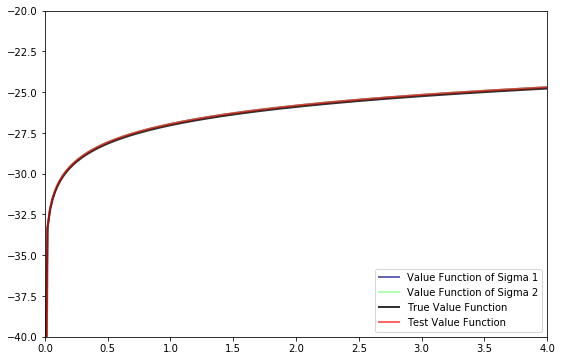

In [103]:
Tw = np.empty(len(grid))
initial_w = 5 * np.log(grid)

sigma_1 = lambda x: 0.95*x
sigma_2 = lambda x: stats.lognorm.cdf(x,0.5)*x

T_1 = lambda w: bellman_operator(w, grid, beta, u, f, sigma_1, shocks)
T_2 = lambda w: bellman_operator(w, grid, beta, u, f, sigma_2, shocks)
T_star = lambda w: bellman_operator(w, grid, beta, u, f, c_star, shocks)

v_1 = qe.compute_fixed_point(T_1, initial_w,1e-5,500,False,10,'iteration')
v_2 = qe.compute_fixed_point(T_2, initial_w,1e-5,500,False,10,'iteration')
test_v = qe.compute_fixed_point(T_star, initial_w,1e-5,500,False,10,'iteration')

#Tw_1 = bellman_operator(sigma_1, v_star_approx, grid, beta, u, f, shocks, com)
#Tw_2 = bellman_operator(sigma_2, v_star_approx, grid, beta, u, f, shocks)
#test_v_star = bellman_operator(c_star, v_star_approx, grid, beta, u, f, shocks)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_ylim(-40, -20)
ax.set_xlim(np.min(grid), np.max(grid))
lb = 'Value Function of Sigma 1'
ax.plot(grid, v_1, color=plt.cm.jet(1), lw=2, alpha=0.6, label=lb)
lb = 'Value Function of Sigma 2'
ax.plot(grid, v_2, color=plt.cm.jet(1/2), lw=2, alpha=0.6, label=lb)
lb = 'True Value Function'
ax.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label=lb)
lb = 'Test Value Function'
ax.plot(grid, test_v, 'r-', lw=2, alpha=0.6, label=lb)
ax.legend(loc='lower right')

plt.show()

1
14.2929161369
2
0.0
1
278.503851202
2
0.0
1
6.22945838613
2
0.0


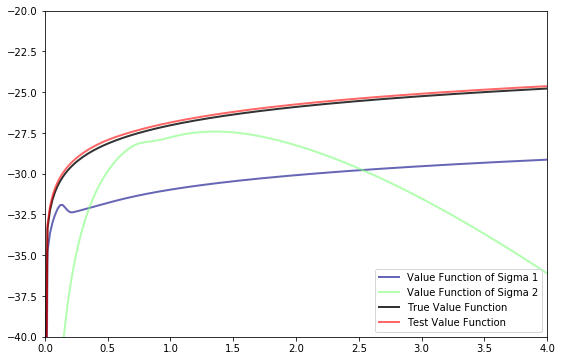

In [78]:
w = 0.99*v_star(grid) # Some initial condition
Tw_1 = compute_v(sigma_1, w, grid, beta, lg.u, lg.f,shocks)
Tw_2 = compute_v(sigma_2, w, grid, beta, lg.u, lg.f,shocks)
test_v = compute_v(lg.c_star, w, grid, beta, lg.u, lg.f,shocks)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_ylim(-40, -20)
ax.set_xlim(np.min(grid), np.max(grid))
lb = 'Value Function of Sigma 1'
ax.plot(grid, Tw_1, color=plt.cm.jet(1), lw=2, alpha=0.6, label=lb)
lb = 'Value Function of Sigma 2'
ax.plot(grid, Tw_2, color=plt.cm.jet(1/2), lw=2, alpha=0.6, label=lb)
lb = 'True Value Function'
ax.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label=lb)
lb = 'Test Value Function'
ax.plot(grid, test_v, 'r-', lw=2, alpha=0.6, label=lb)
ax.legend(loc='lower right')

plt.show()

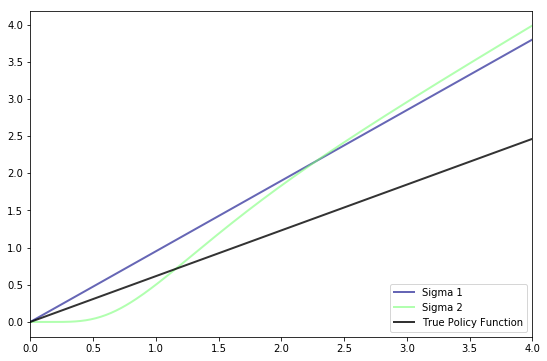

In [48]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_xlim(np.min(grid), np.max(grid))
lb = 'Sigma 1'
ax.plot(grid, sigma_1(grid), color=plt.cm.jet(1), lw=2, alpha=0.6, label=lb)
lb = 'Sigma 2'
ax.plot(grid, sigma_2(grid), color=plt.cm.jet(1/2), lw=2, alpha=0.6, label=lb)
lb = 'True Policy Function'
ax.plot(grid, lg.c_star(grid), 'k-', lw=2, alpha=0.8, label=lb)
ax.legend(loc='lower right')

plt.show()